# Infilling Masking - Corrupting documents by replacing a span of tokens with a special \[MASK] token

### What is token masking?
Token masking is the process of applying a filter to an input sequence of tokens to hide parts of the text in order to train neural networks, specially transformer-based models such as BERT and GPT, to reconstruct the whole context to its original form. This is part of the *training objective* of the transformer which can also be refered as Masked Language Modeling (MLM).

Token masking is beneficial for various NLP tasks, including text classification, named entity recognition, sentiment analysis, and text generation, as it allows models to capture the contextual information within a sentence or text passage. Models like BERT and GPT leverage token masking during pre-training and fine-tuning to achieve state-of-the-art performance on a wide range of NLP tasks.

### What is infilling masking or text infilling?
Text infilling is one of the different techniques used on the original [BART article](https://arxiv.org/pdf/1910.13461) to corrupt documents and optimizing a reconstruction loss. Other than text infilling the authors list different approaches of document corruption such as *token masking*, *token deletion*, *sentence permutation* and *document rotation*. See below:

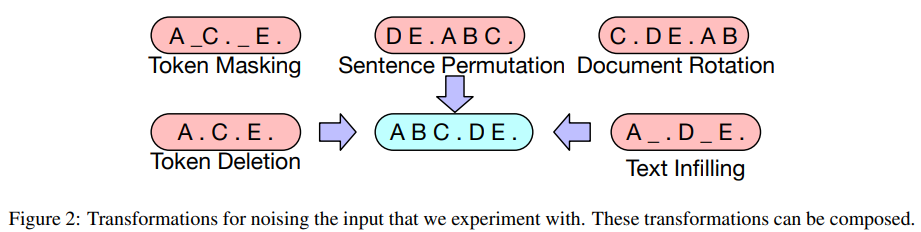

### Text infilling steps
1- Tokenize the sequence text, create a special_tokens_mask to account for special tokens like [BOS] *Begin of Sentence*, [EOS] *End of Sentence* or even [MASK] tokens and count the number of valid tokens to generate a *mask budget* based on a percentage value. The authors have been inspired by the [SpanBERT article](https://arxiv.org/abs/1907.10529) which applies mask to 15% of tokens.

2- Sample from a Poisson distribution the length size of the span to be applied and sample a start token to apply the mask randomly (uniformly). The Poisson distribution may return a 0-length span, for which the start token is determined and the [MASK] token is added. I.e. the model should also be able to predict whether there should be a actual token/group of tokens or not.

3- Re-apply step 2 until the *mask budget* has been fully consumed.

### My motivation

#### The context
In my current occupation my team and I have been asked to finetune a pretrained language model to summarize customer service conversations to know more about the operational health of the customer service.

#### Model selection
Our approach to model selection was to finetune different architectures of LLMs using a few hand-written summaries. We combined this approach with this super useful [article](https://towardsdatascience.com/choosing-the-right-language-model-for-your-nlp-use-case-1288ef3c4929) that has a really interesting table with the compatibility of different architectures to different downstream tasks. 

Our favourite candidates were google-t5 and facebook-BART models. The later led to better results probably due to the encoder-decoder architecture in which the encoder structure was able to extract more useful embedding context from the customer service conversations.

#### First results using BART
Our first approaches using zero-shot and few-shot techniques provided decent results. However the limited labled data was not enough to achieve the expected results and the finetuned model was not able to fully handle the domain-specific terminology. This led us to the possibility of further pretrain our model using domain-specific data.

#### Why text infilling?
After selecting the model and realizing some domain-adaptation was needed I turned to the original BART [article](https://arxiv.org/pdf/1910.13461). On section 3 the authors list all the possible downstream tasks for which the model could be fine-tuned. On section 4 the authors compared the different document corruption approaches by pre-training one BART model for each approach and further fine-tuned it using common datasets used as benchmaks and finally compared the resulting metrics. See below:

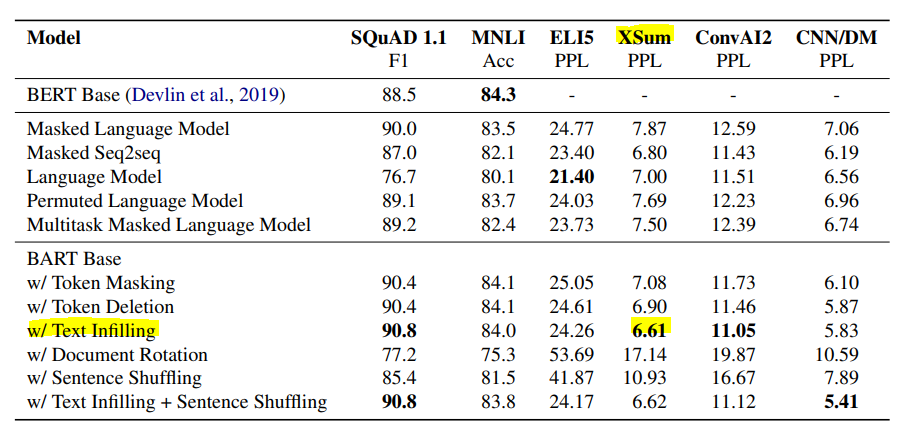

What is going on:
- Extreme Summarizatoin (XSum) is a [news summarization dataset](https://huggingface.co/datasets/xsum) in which a news article is summarizede in one sentence. Therefore this dataset contains highly abstractive summaries.
- [Perplexity](https://huggingface.co/docs/transformers/en/perplexity) (PPL) is one of the most common metrics for evaluating LMs which measures how well the model is capable of predicting the next token for a given context. It is equivalent to the exponentiation of the cross-entropy, therefore the lower the more comprehensive the model is.
- All the models have been pre-trained for 1M steps on a combination of books and wikipedia data. The bottom block displays the results of pre-training a BART-base model - which has 6 encoder and 6 decoder blocks - and further fine-tunning on each downstream task. Although the authors' state, on section 4.1, that for every pretraining objective they needed to apply minor changes on learning rate and layer normalization in order to improve performance, the results can be viewed as consistent. The authors's conclude that however performance varies considerably across tasks, <u>BART models pre-trained using **text infilling** have provided the most consistently strong performance</u>.

#### Next steps
- Finetune BART model to our domain-specific data using the coded class `DataCollatorForTextInfilling`.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

##################
# Minimal imports
import numpy as np
from typing import (List, 
                    Dict,
                    Optional,
                    Union)
import math
from copy import deepcopy

from transformers import (PreTrainedTokenizer,
                          BartTokenizer)
from transformers.utils import PaddingStrategy
from transformers.tokenization_utils_base import (BatchEncoding,
                                                  PreTrainedTokenizerBase)
##################
# Used on sample code
import torch

## DataCollatorForTextInfilling

In [2]:
class DataCollatorForTextInfilling:
    def __init__(self, 
                 tokenizer: PreTrainedTokenizerBase,
                 mlm_probability: float=0.15,
                 poisson_lambda: float=3.0,
                 padding: Union[bool, str, PaddingStrategy]=True,
                 max_length: Optional[int]=None,
                 pad_to_multiple_of: Optional[int]=None, 
                 return_attention_mask: bool=True,
                 label_pad_token_id: int=-100,
                 return_tensors: str="pt"):
        """
        Data collator for text infilling mask based on the original BART
        article: https://arxiv.org/pdf/1910.13461.pdf.
        
        Draws a span length from a poisson distribution, selects the starting
        token randomly (uniformly) and applies the masking of the span length sequence
        of tokens.
        
        The poisson distribution may return a span length of 0 for which the
        <mask> token will be added for the provided location.
        
        Args:
            tokenizer (PreTrainedTokenizerBase): Pretrained tokenizer.
            mlm_probability (float): Percentage of tokens to be masked. 
                Default is 0.15.
            poisson_lambda (float): Poisson Lambda - i.e. expected value.
                Default is 3.0 following the original BART article.
            padding (Union[bool, str, PaddingStrategy]): Padding strategy.
                Default is True.
            max_length (int): Max sequence length for both input_ids and labels.
                Default is None.
            pad_to_multiple_of (int): Set the padding dimension to a multiple.
                Useful for mixed precision training. 
                Default is None.
            return_attention_mask (bool): Whether to return attention_mask.
                Default is True.
            label_pad_token_id (int): pad token for labels.
                Default is -100.
            return_tensors (str): Type of tensors to be returned. 
                Available types are 'pt', 'tf' and 'np'.
                Default is 'pt'.
        """
        self.tokenizer = tokenizer
        self.mlm_probability = mlm_probability
        self.poisson_lambda = poisson_lambda
        self.padding = padding
        self.max_length = max_length
        self.pad_to_multiple_of = pad_to_multiple_of
        self.return_attention_mask = return_attention_mask
        self.label_pad_token_id = label_pad_token_id 
        self.return_tensors = return_tensors
        self.mask_token_id = self.tokenizer.mask_token_id
        self.pad_token_id = self.tokenizer.pad_token_id
        
        
    def __call__(self, 
                 samples: Union[BatchEncoding, List[Dict[str, List[int]]]]) -> BatchEncoding:
        """
        Applies infilling masking to sequence of ids.
        
        Args:
            samples (Union[BatchEncoding, List[Dict[str, List[int]]]]): 
                Batch of sequence of input_ids.
        
        Returns:
            BatchEncoding
        """
        if isinstance(samples, list):
            # Fetch input_ids
            input_ids = [deepcopy(sample["input_ids"]) for sample in samples]
            # Pad the input_ids
            input_ids = self.tokenizer.pad({"input_ids": input_ids}, 
                                           padding=self.padding,
                                           max_length=self.max_length,
                                           return_attention_mask=False)["input_ids"]
            # Create labels
            labels = deepcopy(input_ids)

        elif isinstance(samples, (dict, BatchEncoding)):
            input_ids = deepcopy(samples["input_ids"])
            
            # Batch size of 1 with no column - i.e. ndim=1
            if isinstance(input_ids[0], int):
                input_ids = [input_ids]
            # Create labels
            labels = deepcopy(samples["input_ids"])
            
        else:
            raise TypeError(f"Unsuported type '{type(samples)}' for `samples`.")
            
        # Remove <pad> tokens - later we'll call the tokenizer pad() method
        # which does not account for present <pad> tokens
        # The masking scheme will change the sizes anyways
        input_ids = [self._remove_pad_tokens(ids) for ids in input_ids]

        # Apply masking
        input_ids_masked = [self._mask_tokens(ids) for ids in input_ids]

        # Properly pad input_ids
        encoded_inputs = {"input_ids": input_ids_masked}
        encoded_inputs = self.tokenizer.pad(encoded_inputs,
                                            padding=self.padding,
                                            max_length=self.max_length,
                                            pad_to_multiple_of=self.pad_to_multiple_of,
                                            return_attention_mask=self.return_attention_mask)
        
        # Replace pad tokens on labels with label_pad_token_id 
        # Default is -100 - i.e. ignored by the loss calculation
        labels = np.array(labels)
        labels[labels == self.pad_token_id] = self.label_pad_token_id
        
        # Add labels
        encoded_inputs.update({"labels": labels})
        return BatchEncoding(encoded_inputs, tensor_type=self.return_tensors)
            
    
    
    def _get_lengths(self, num_to_mask: int) -> List:
        """
        Return a list of span lengths drawn from a poisson distribution.
        The sum of the resulting list's items is equal to the `num_to_mask` 
        amount of tokens.
        
        Args:
            num_to_mask (int): Amount of tokens to be masked
            
        Returns:
            lengths (List): List of span lengths
        """
        mask_budget = num_to_mask
        lengths = []
        # Draw span lengths from poisson distribution until mask_budget is <= 0
        while mask_budget > 0:
            # Draw span length
            span_length = np.random.poisson(lam=self.poisson_lambda, size=(1,))
            lengths.append(span_length[0])
            
            # Update mask budget
            mask_budget -= span_length[0]
            
        # Adjust last span_length if mask_budget < 0
        if mask_budget < 0:
            discount = np.sum(lengths) - num_to_mask
            lengths[-1] -= discount
        return lengths
    
    
    def _get_start_pos(self, 
                       input_ids: List[int],
                       special_tokens_mask: List[bool],
                       span_length: int) -> List[int]:
        """
        Applies a span length to a sequence of input_ids based on the
        original span BERT https://arxiv.org/pdf/1907.10529.pdf article
        as referenced on the BART article under 'text infilling' strategy.
        
        Args:
            input_ids (List[int]): Sequence of input_ids.
            special_tokens_mask (List[int]): Special tokens mask.
            span_length (int): Amount of tokens to be masked.
            
        Returns:
            start_pos (int): Location of the starting token to be spanned.
        """
        # Value check span length
        if span_length < 0:
            raise ValueError("span_length must be greater than 0.")
            
        # Get actual tokens
        is_token = np.array(~special_tokens_mask, dtype=bool)
        
        while True:
            # Get possible starting locations randomly (uniformly)
            start_locs = np.random.uniform(size=(len(input_ids),)) * (is_token).astype(int)
            start_pos = np.argmax(start_locs)

            # Return the position if span_length is 0
            # for which the <mask> token should be added
            if not span_length:
                return start_pos

            # Check if location is valid, i.e. there's no overlapping with any special tokens
            # And check if the amount of tokens to be masked matches the provided span_length
            span_tokens = is_token[start_pos: start_pos + span_length]
            if not any(~span_tokens) and len(span_tokens) == span_length:
                return start_pos
    
    
    def _remove_pad_tokens(self, input_ids: List[int]) -> List[int]:
        """
        Remove <pad> token from input_ids sequence
        """
        return [ids for ids in input_ids if ids != self.pad_token_id]
    
    
    def _mask_tokens(self, input_ids: List[int]) -> List[int]:
        """
        Apply infilling masking scheme based on https://arxiv.org/pdf/1910.13461.pdf.
        
        Args:
            input_ids (List[int]): Sequence of input_ids.
            
        Returns:
            input_ids_copy (List[int]): Sequence of input_ids with mask tokens.
        """
        input_ids_copy = np.array(input_ids)
        
        # Get special tokens mask
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(input_ids_copy.tolist(),
                                                                     already_has_special_tokens=True)
        special_tokens_mask = np.array(special_tokens_mask, dtype=bool)
        
        # Get actual tokens
        is_token = ~special_tokens_mask
        
        # Check how many tokens to be masked
        num_to_mask = int(math.ceil(is_token.sum() * self.mlm_probability))
        
        # Input sequence must at least have a normal token
        # This prevents from outputing a sequence with only special_tokens
        # So just default to a span length of zero to insert a mask token
        if num_to_mask == 0 or num_to_mask - int(is_token.sum()) == 0:
            # Get start position
            start_pos = self._get_start_pos(input_ids_copy,
                                            special_tokens_mask,
                                            span_length=0)
            return np.insert(input_ids_copy, 
                             start_pos,
                             self.mask_token_id).tolist()
        
        # Get the list of span lengths that add to num_to_mask
        lengths = self._get_lengths(num_to_mask)
        
        # Apply infilling masking
        for span_length in lengths:
            # Get start position
            start_pos = self._get_start_pos(input_ids_copy,
                                            special_tokens_mask,
                                            span_length)
            
            # Apply masking
            if not span_length:
                # Insert mask token if span_length is 0
                np.insert(input_ids_copy,
                          start_pos,
                          self.mask_token_id).tolist()
            else:
                # Span masking
                input_ids_copy = np.concatenate((input_ids_copy[:start_pos], 
                                                 np.array([self.mask_token_id]),
                                                 input_ids_copy[start_pos + span_length:]))
            
            # Re-create special_tokens_mask accounting for the masked tokens
            special_tokens_mask = self.tokenizer.get_special_tokens_mask(input_ids_copy.tolist(),
                                                             already_has_special_tokens=True)
            special_tokens_mask = np.array(special_tokens_mask, dtype=bool)
        
        return input_ids_copy.tolist()

## Sample usage

In [3]:
checkpoint = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(checkpoint)

### Create a custom dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,
                 tokenizer: PreTrainedTokenizerBase,
                 texts: List[str],
                 **tok_kwargs) -> None:
        """
        Simple Dataset with __len__ and __getitem__ methods.
        """
        if not isinstance(texts, list) or\
            not all(isinstance(t, str) for t in texts):
            raise TypeError("`texts` must be a list of strings.")
            
        self.tokenizer = tokenizer
        self.texts = texts
        self.tok_kwargs = tok_kwargs or None
        
        
    def __len__(self):
        return len(self.texts)
    
    
    def __getitem__(self, idx):
        return self.tokenizer(self.texts[idx],
                              **self.tok_kwargs)

### Wrap everything with a DataLoader

In [5]:
# Dummy data
texts = ["This is my first sequence of words.", 
         "This is another sequence of words, but longer.", 
         "Here's another example of sequence."]

# Create a dataset
dataset = CustomDataset(tokenizer,
                        texts,
                        truncation=True,
                        max_length=512,
                        padding=True)

# Create the data_collator
data_collator = DataCollatorForTextInfilling(tokenizer,
                                             max_length=512)

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle=True,
                                          collate_fn=data_collator)

### Train

In [6]:
# Iterate over batches
for batch in data_loader:
    print({k: v.shape for k, v in batch.items()})

{'input_ids': torch.Size([2, 11]), 'attention_mask': torch.Size([2, 11]), 'labels': torch.Size([2, 12])}
{'input_ids': torch.Size([1, 9]), 'attention_mask': torch.Size([1, 9]), 'labels': torch.Size([1, 10])}


In [7]:
batch

{'input_ids': tensor([[    0,   713,    16,   127,    78, 13931,     9, 50264,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[    0,   713,    16,   127,    78, 13931,     9,  1617,     4,     2]],
       dtype=torch.int32)}